<a href="https://colab.research.google.com/github/sol-sun/Generative_Deep_Learning_2nd_Pytorch/blob/main/07_ebm/ebm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚡️ エネルギーベースモデル

本ノートブックでは，MNISTデータセットを用いたエネルギーベースモデルの実装を行う．

In [ ]:
!pip install datasets | tail -n 1
!pip install japanize_matplotlib | tail -n 1
!pip install kagglehub | tail -n 1
!pip install torchinfo | tail -n 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import numpy as np
import os
import re
import string
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
from datasets import Dataset as HFDataset
import torchvision
import torch
import torchinfo
import random
import json
import pandas as pd
import kagglehub
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoTokenizer, PretrainedConfig, PreTrainedModel, pipeline
from transformers.models.auto.modeling_auto import MODEL_FOR_CAUSAL_LM_MAPPING_NAMES
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


import sys
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121
0.20.1+cu121


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)  # ディレクトリを作成
    model.eval()
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

def save_metrics(metrics_per_epoch, filename):
    # ディレクトリが存在しない場合は作成
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    # ファイルにメトリクスを保存
    with open(filename, "w") as f:
        json.dump(metrics_per_epoch, f, indent=2)

# シード値を設定
set_seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


## 0. パラメータ

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 80 #60
LOAD_MODEL = False

## 1. MNISTデータセットの準備

In [ ]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        torchvision.transforms.ToTensor(),
    ])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 45.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 4.45MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.55MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

(1, 32, 32)


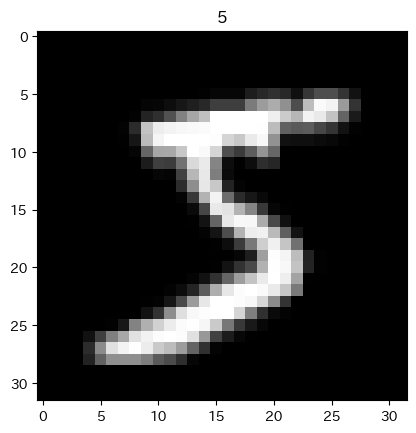

In [ ]:
print(trainset)
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
plt.imshow(trainset[0][0].permute(1,2,0), cmap="gray")
plt.title(trainset[0][1])
plt.show()

## 2. EBMモデルの構築

In [ ]:
class EnergyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.energy_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5), stride=2, padding=2),
            nn.SiLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(in_features=64 * 2 * 2, out_features=1),
        )

    def forward(self, x):
        return self.energy_model(x)

In [ ]:
def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    # inp_imgs: 入力画像
    # steps: サンプリングのステップ数
    # step_size: サンプリングのステップサイズ
    # noise: ノイズの幅
    inp_imgs.requires_grad = True
    imgs_per_step = []
    for _ in range(steps):  # ステップ数分ループ
        inp_imgs = inp_imgs + torch.randn_like(inp_imgs) * noise  # 画像に少量にノイズを加える
        inp_imgs = torch.clamp(inp_imgs, min=-1.0, max=1.0)

        out = model(inp_imgs)
        grads = torch.autograd.grad(
            outputs=out,
            inputs=inp_imgs,
            grad_outputs=torch.ones_like(out),
            create_graph=False,
            retain_graph=False,
            only_inputs=True)[0]
        grads = torch.clamp(grads, min=-GRADIENT_CLIP, max=GRADIENT_CLIP)
        inp_imgs = inp_imgs - (step_size * grads)
        inp_imgs = torch.clamp(inp_imgs, min=-1.0, max=1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs.detach())

    if return_img_per_step:
        return torch.cat(imgs_per_step, dim=0)
    else:
        return inp_imgs.detach()

In [ ]:
class Buffer:
    def __init__(self, model, device):
        super().__init__()
        self.energy_model = model
        self.device = device
        self.examples = torch.cat([torch.rand((1, 1, IMAGE_SIZE, IMAGE_SIZE),device=device) * 2 - 1 for _ in range(BATCH_SIZE)])

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)  # バッチサイズの範囲で5%を選択
        rand_imgs = torch.rand(n_new, 1, IMAGE_SIZE, IMAGE_SIZE, device=self.device) * 2 - 1  # 選んだ数だけ-1から1の一様分布で画像を生成
        old_imgs = torch.stack(random.choices(self.examples, k=(BATCH_SIZE - n_new)),
                             dim=0)  # 合計でバッチサイズ分になるようにself.examplesからランダムに選択
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0)
        inp_imgs = generate_samples(
            self.energy_model, inp_imgs.to(self.device), steps=steps, step_size=step_size, noise=noise
        )
        self.examples = torch.cat([inp_imgs, self.examples], dim=0)
        self.examples = self.examples[:BUFFER_SIZE]

        return inp_imgs

In [ ]:
class EBM(nn.Module):
    def __init__(self, model, device):
        super().__init__()
        self.energy_model = model
        self.device = device
        self.buffer = Buffer(self.energy_model, device=device)
        self.alpha = ALPHA
        self.loss = {"loss": 0,
                     "reg_loss": 0,
                     "cdiv_loss": 0,
                     "real_out": 0,
                     "fake_out": 0
                     }
        self.eval_loss = {"loss": 0,
                          "reg_loss": 0,
                          "cdiv_loss": 0,
                          "real_out": 0,
                          "fake_out": 0}

    def metrics_reset(self):
        for key in self.loss:
            self.loss[key] = 0
        for key in self.eval_loss:
            self.eval_loss[key] = 0


    def forward(self, real_imgs):
        real_imgs += torch.randn_like(real_imgs) * NOISE
        batch_size = real_imgs.size()[0]
        real_imgs = torch.clamp(real_imgs, min=-1.0, max=1.0)
        fake_imgs = self.buffer.sample_new_exmps(STEPS, STEP_SIZE, NOISE)
        fake_imgs = fake_imgs[:batch_size]
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)

        real_out, fake_out = torch.split(self.energy_model(inp_imgs), batch_size, dim=0)
        #cdiv_loss = torch.mean(fake_out, dim=0, keepdim=False) - torch.mean(real_out, dim=0, keepdim=False)
        cdiv_loss =  torch.mean(real_out.mean(), dim=0, keepdim=False) - torch.mean(fake_out, dim=0, keepdim=False)
        reg_loss = self.alpha * torch.mean(real_out ** 2 + fake_out ** 2, dim=0, keepdim=False)
        loss = cdiv_loss + reg_loss

        self.loss["loss"] += loss.item()
        self.loss["reg_loss"] += reg_loss.item()
        self.loss["cdiv_loss"] += cdiv_loss.item()
        self.loss["real_out"] += torch.mean(real_out.detach(), dim=0).item()
        self.loss["fake_out"] += torch.mean(fake_out.detach(), dim=0).item()

        return loss

    def test_step(self, real_imgs):
        real_imgs += torch.randn_like(real_imgs) * NOISE
        batch_size = real_imgs.size()[0]
        real_imgs = torch.clamp(real_imgs, min=-1.0, max=1.0)
        fake_imgs = torch.rand(batch_size, 1, IMAGE_SIZE, IMAGE_SIZE, device=self.device) * 2 - 1
        #fake_imgs = self.buffer.sample_new_exmps(STEPS, STEP_SIZE, NOISE)
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)

        real_out, fake_out = torch.split(self.energy_model(inp_imgs), batch_size, dim=0)
        cdiv_loss = torch.mean(real_out, dim=0, keepdim=False) - torch.mean(fake_out, dim=0, keepdim=False)

        self.eval_loss["cdiv_loss"] += cdiv_loss.item()
        self.eval_loss["real_out"] += torch.mean(real_out.detach(), dim=0).item()
        self.eval_loss["fake_out"] += torch.mean(fake_out.detach(), dim=0).item()

        return True

In [ ]:
energy_model = EnergyModel()
print(torchinfo.summary(energy_model.eval(), input_size=(1, 1, IMAGE_SIZE, IMAGE_SIZE)))
model = EBM(energy_model, device=device)
model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
EnergyModel                              [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 16, 16, 16]           416
│    └─SiLU: 2-2                         [1, 16, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 32, 8, 8]             4,640
│    └─SiLU: 2-4                         [1, 32, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 64, 4, 4]             18,496
│    └─SiLU: 2-6                         [1, 64, 4, 4]             --
│    └─Conv2d: 2-7                       [1, 64, 2, 2]             36,928
│    └─Flatten: 2-8                      [1, 256]                  --
│    └─Linear: 2-9                       [1, 1]                    257
Total params: 60,737
Trainable params: 60,737
Non-trainable params: 0
Total mult-adds (M): 0.85
Input size (MB): 0.00
Forward/backward pass si

## 3. EBMネットワークの学習

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# metrics_per_epoch = {
#         "loss": [],
#         "reg_loss": [],
#         "cdiv_loss": [],
#         "real_out": [],
#         "fake_out": []
#     }
# eval_metrics_per_epoch = {
#         "cdiv_loss":[],
#         "real_out": [],
#         "fake_out": []
#     }

# for epoch in range(EPOCHS):
#     epoch_metrics = {metric: 0 for metric in metrics_per_epoch}
#     eval_epoch_metrics = {metric: 0 for metric in eval_metrics_per_epoch}
#     batch_count = 0
#     eval_batch_count = 0
#     model.metrics_reset()
#     # train
#     model.train()
#     for i, data in enumerate(trainloader, 0):
#         images, _ = data
#         images = images.to(device)
#         optimizer.zero_grad()

#         loss = model(images)
#         loss.backward()
#         optimizer.step()
#         batch_count += 1
#     # test
#     model.eval()

#     for i, data in enumerate(testloader, 0):
#         images, _ = data
#         images = images.to(device)

#         ret = model.test_step(images)
#         eval_batch_count += 1

#     for key in epoch_metrics:
#         epoch_metrics[key] = model.loss[key]
#         epoch_metrics[key] /= batch_count
#         metrics_per_epoch[key].append(epoch_metrics[key])
#     for key in eval_metrics_per_epoch:
#         eval_epoch_metrics[key] = model.eval_loss[key]
#         eval_epoch_metrics[key] /= eval_batch_count
#         eval_metrics_per_epoch[key].append(eval_epoch_metrics[key])

#     # epoch終了時点でのlossの平均値
#     print("Epoch {}:".format(epoch + 1), epoch_metrics)
#     print("Epoch(Eval) {}:".format(epoch + 1), eval_epoch_metrics)

In [ ]:
# # modelを保存
# save_path = f"./models/ebm_epoch_{EPOCHS}.pth"

# save_model(model, save_path)

# # metricsを保存
# metrics_save_path = f"./metrics/ebm_metrics.json"
# save_metrics(metrics_per_epoch=metrics_per_epoch, filename=metrics_save_path)
# eval_metrics_save_path = f"./metrics/eval_ebm_metrics.json"
# save_metrics(metrics_per_epoch=eval_metrics_per_epoch, filename=eval_metrics_save_path)

In [ ]:
import urllib.request

# モデルのURL
model_url = "https://github.com/sol-sun/Generative_Deep_Learning_2nd_Pytorch/raw/main/07_ebm/models/ebm_epoch_80.pth"
local_model_path = "ebm_epoch_80.pth"

# モデルをダウンロード
urllib.request.urlretrieve(model_url, local_model_path)
# Move the model to the device and load it
model = load_model(model, local_model_path, device)

# モデルのURL
model_url = "https://github.com/sol-sun/Generative_Deep_Learning_2nd_Pytorch/raw/main/07_ebm/metrics/eval_ebm_metrics.json"
local_model_path = "eval_ebm_metrics.json"
urllib.request.urlretrieve(model_url, local_model_path)
model_url = "https://github.com/sol-sun/Generative_Deep_Learning_2nd_Pytorch/raw/main/07_ebm/metrics/ebm_metrics.json"
local_model_path = "ebm_metrics.json"
urllib.request.urlretrieve(model_url, local_model_path)

Model loaded from ebm_epoch_80.pth


('ebm_metrics.json', <http.client.HTTPMessage at 0x7d6f2262fcd0>)

## 4. 画像の生成

In [ ]:
num_samples = 10
model.eval()
start_imgs = (
        np.random.uniform(size=(num_samples, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)) * 2 - 1
)
start_imgs = torch.from_numpy(start_imgs).float().to(device)
out = generate_samples(model.energy_model, start_imgs, 1000, STEP_SIZE, NOISE)
images = (torch.clamp(out, 0, 1).cpu().detach().numpy())

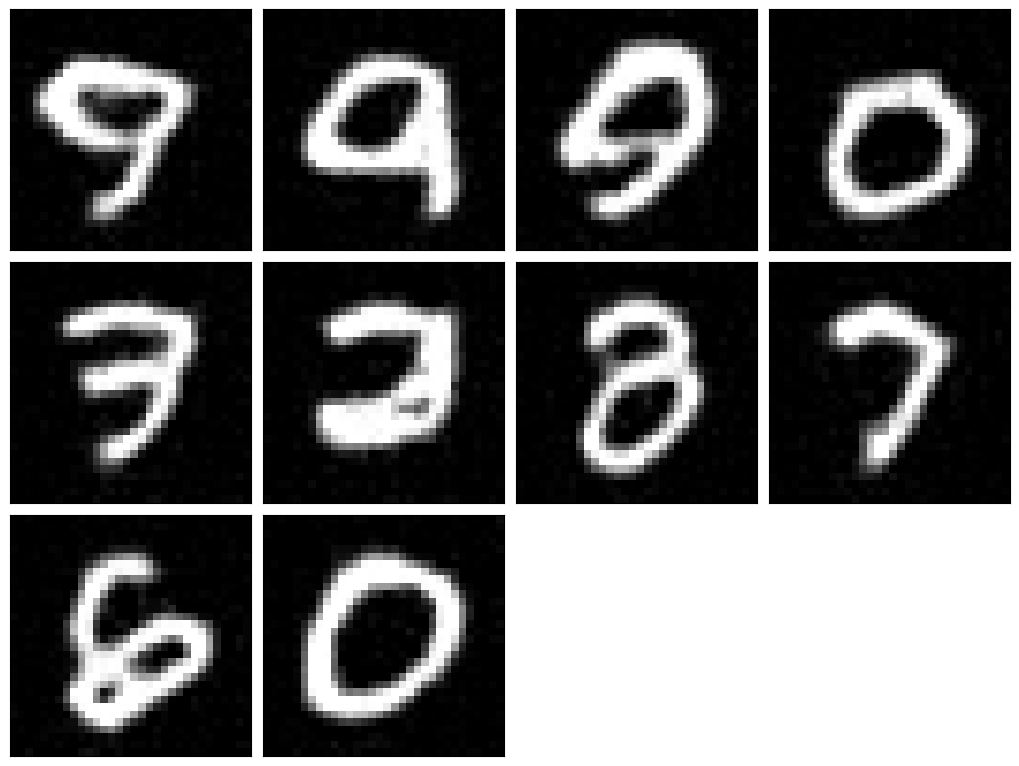

In [ ]:
# 画像を図示する
def plot_images(generated_images):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(generated_images.shape[0]):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(generated_images[i].transpose(1,2,0), cmap="gray")
    plt.show()

plot_images(images)

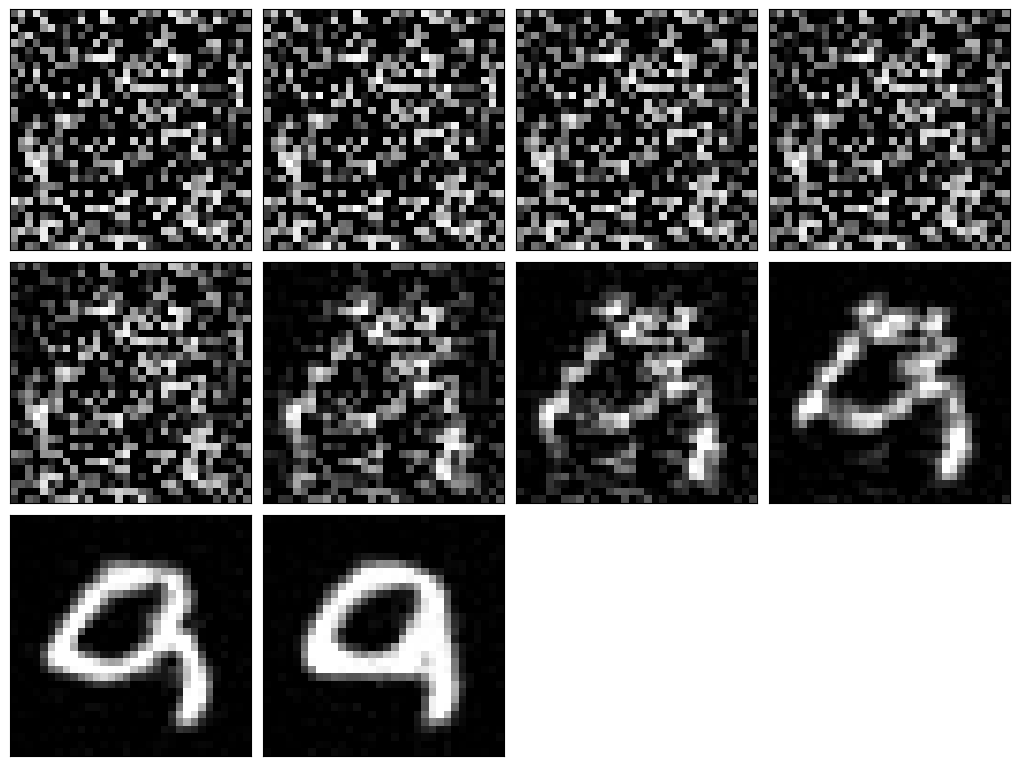

In [ ]:
out = generate_samples(model.energy_model, start_imgs, 1000, STEP_SIZE, NOISE, return_img_per_step=True)
imgs = []
sample_idx = 1 # 画像を表示するサンプルのインデックス
var_step = [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]
for step in var_step:
    imgs.append(torch.clamp(out[step*num_samples + sample_idx], 0, 1).cpu().detach().numpy()[:, np.newaxis, :, :])
imgs = np.concatenate(imgs)
plot_images(imgs)

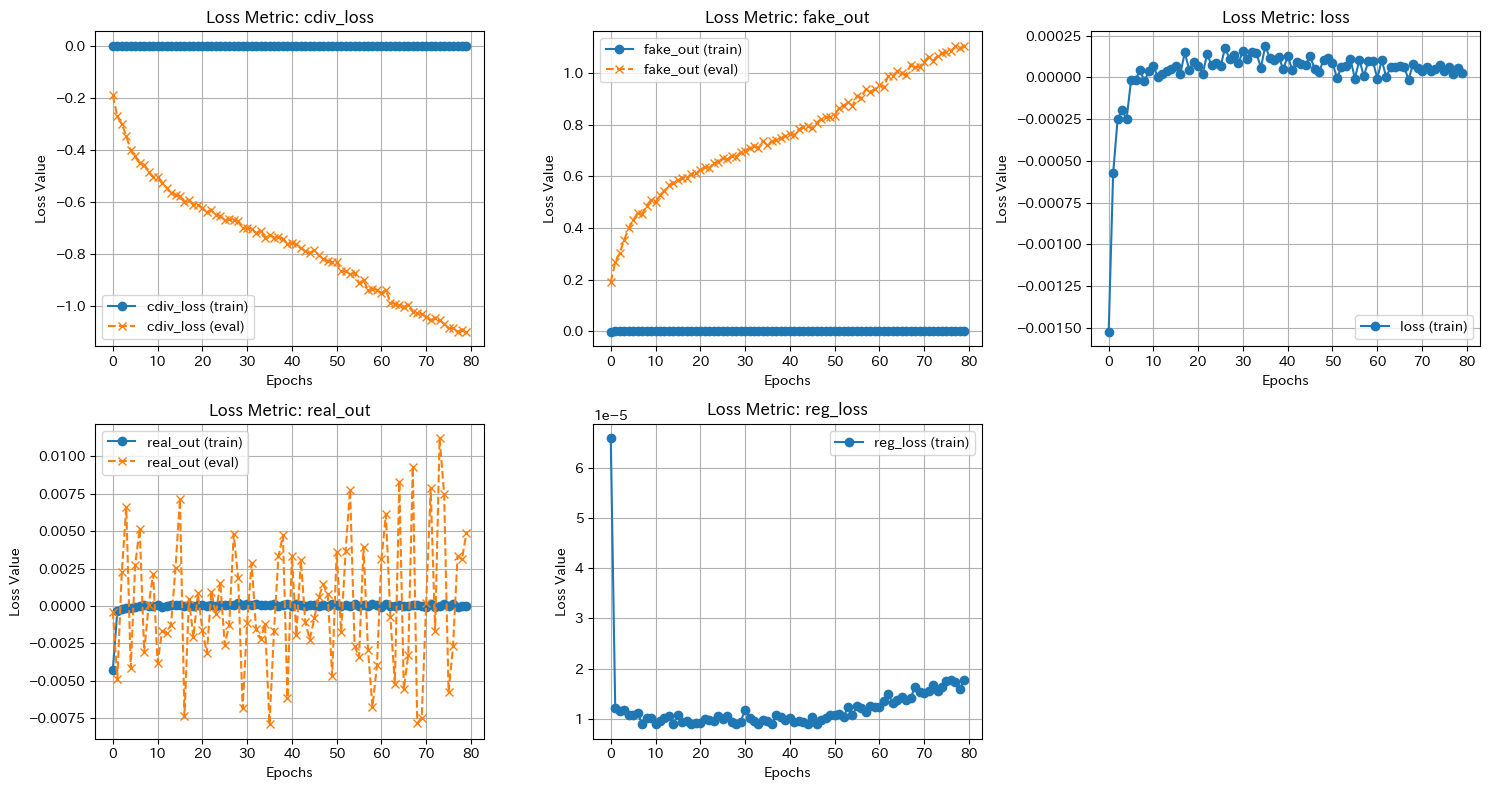

In [ ]:
import json
import matplotlib.pyplot as plt
import math

def plot_loss_metrics_with_subplots(metrics_path_1, metrics_path_2):
    """
    Plot loss metrics from two JSON files using subplots.
    - Loss types present in both files are plotted on the same subplot.
    - Unique loss types are plotted separately.

    Parameters:
        metrics_path_1 (str): Path to the first metrics JSON file (train data).
        metrics_path_2 (str): Path to the second metrics JSON file (eval data).
    """
    # Load JSON files
    with open(metrics_path_1, 'r') as f1, open(metrics_path_2, 'r') as f2:
        metrics_1 = json.load(f1)
        metrics_2 = json.load(f2)

    # Combine keys from both metrics files
    all_loss_types = sorted(set(metrics_1.keys()).union(metrics_2.keys()))

    # Calculate grid size for subplots
    num_plots = len(all_loss_types)
    cols = 3
    rows = math.ceil(num_plots / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows/columns

    for idx, loss_type in enumerate(all_loss_types):
        ax = axes[idx]

        # Plot data from metrics_1 (train) if available
        if loss_type in metrics_1:
            ax.plot(metrics_1[loss_type], label=f'{loss_type} (train)', linestyle='-', marker='o')

        # Plot data from metrics_2 (eval) if available
        if loss_type in metrics_2:
            ax.plot(metrics_2[loss_type], label=f'{loss_type} (eval)', linestyle='--', marker='x')

        # Customize the subplot
        ax.set_title(f'Loss Metric: {loss_type}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss Value')
        ax.legend()
        ax.grid(True)

    # Hide any unused subplots
    for idx in range(num_plots, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example
plot_loss_metrics_with_subplots('./ebm_metrics.json', './eval_ebm_metrics.json')